# Tensorflow Object Detection Modified API Hands-on

- 본 Note는 tensorflow object detection API실습을 위한 자료입니다.
- 대부분의 Tensorflow  object detection API 관련 튜토리얼이나 오픈소스들은  Tensorflow API를 모두 다운받아서 활용하는 법으로 설명 되어 있습니다. 
- 그러나 최신 버전의 Tensorflow API를 모두 다운 받는 것은 object detection 구현만을 위해서는 불필요한 파일을 다운 받게되어 용량이크고 시간이 많이 들게 됩니다. 또한, 현재도 계속 업데이트 되고 있는 최신버전의 Tensorflow API를 다운받아 이용할 경우 오류가 발생할 확률이 높아 필요 라이브러리 및 소스 버전이 feezing 된 아래의 깃헙에 있는 modified API를 다운 받습니다.
- 실습 code는 기본적으로 tensorflow 에서 제공된 tutorial code를 이용하여였지만, colab 상에서 실습이 이루어 질 수 있도록 수정을 하였습니다.
- 배경지식 및 기본 이론설명, code review는 hands-on 강의를 들으시는 분들과의 차별성을 위해 최소화 했음을 양해해 주시기 바랍니다.


# Part 1.Install Tensorflow Object detection modified API
- 실습전 colab 런타임 유형설정이 Python3, 하드웨어 가속은 GPU로 설정 되어 있는지 재 확인 합니다.
- 아래의 필요 라이브러리 및 버전 feezing 된 modified API를 특정 깃헙에서 다운 받습니다.
- 다운이 완료될 경우 좌측의 colab explorer 파일 탭에서 "TF_object_detection_Modified_API"라는 폴더를 확인 할 수 있습니다.

In [1]:
!git clone https://github.com/sunnys-lab/TF_object_detection_Modified_API

Cloning into 'TF_object_detection_Modified_API'...
remote: Enumerating objects: 663, done.
remote: Counting objects: 100% (663/663), done.
remote: Compressing objects: 100% (434/434), done.
remote: Total 663 (delta 218), reused 649 (delta 209), pack-reused 0
Receiving objects: 100% (663/663), 18.22 MiB | 23.71 MiB/s, done.
Resolving deltas: 100% (218/218), done.


# Part 2. Object Detection with Pre-trained model

- 본 part는 tensorflow 기반에서 pre-trained model을 이용한 object detection 실습을 위한 part 입니다.


## Step 1.Install pre-requirement files & libraries
- 아래의 필수 파일 및 라이브러리 설치 및 복사를 실행합니다.

In [0]:
!apt-get -qq install libprotobuf-java protobuf-compiler
!protoc ./TF_object_detection_Modified_API/object_detection/protos/string_int_label_map.proto --python_out=.
!cp -rf /content/TF_object_detection_Modified_API/* /content/
!rm -r /content/TF_object_detection_Modified_API/

## Step 2. Import Libraries
- 필요 라이브러리 import
- Jupyter Notebook에서 이미지를 바로 볼수 있도록 matplotlib inline 설정



In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt

from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
# This is needed to display the images.
%matplotlib inline

## Step 3.Pre Trained model implemenation
- tensorflow에 있는 pre-trained model download 및 implementation 하는 부분입니다.
- MODEL_NAME 을 변경 함으로써  원하는 pre-trained model 을 사용할 수 있습니다.

In [5]:
# What model to download.
# MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
# model with more accurancy but up to you use a diferent model
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2017_11_08'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())
    
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

W0630 16:01:48.058641 140274220828544 deprecation_wrapper.py:119] From /content/object_detection/utils/label_map_util.py:131: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



## Step 4. Test용 이미지상에서 detection
- 테스트 이미지가 있는 경로 설정 합니다. (본 예제에서는 ./test_images 폴더에 테스트 이미지가 있습니다.)
- 추가로 테스트 하고 싶은 이미지가 있을 경우 colab 화면 좌측 탭에서 "목차" 탭 대신에 파일" 탭을 클릭하고 object_detection/test_images 폴더를 오른쪽 마우스 클릭으로 선택한 후 추가 이미지를 업로드 하면 됩니다.
- 추가 업로드 이미지는 images{}.jpg 포맷에 맞추어 숫자를 일련번호로 입력하면되며, 아래의 소스 코드에서 range 값을 (1, 일련번호+1) 값으로  증가 시켜 주면 됩니다.


In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = './test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

- 각 테스트 이미지에 대한 object detection 실시

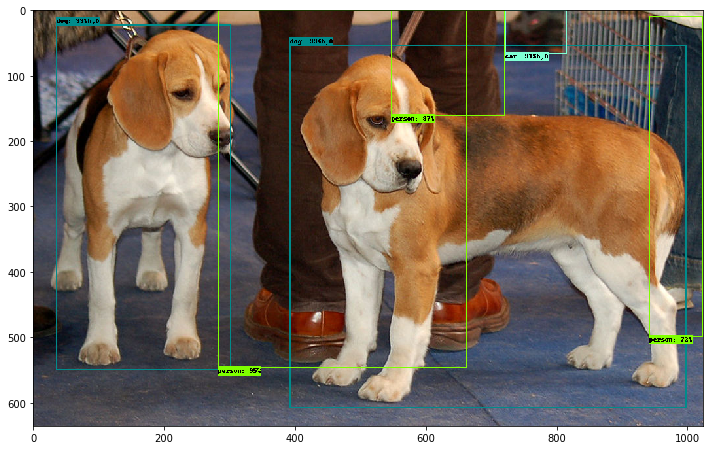

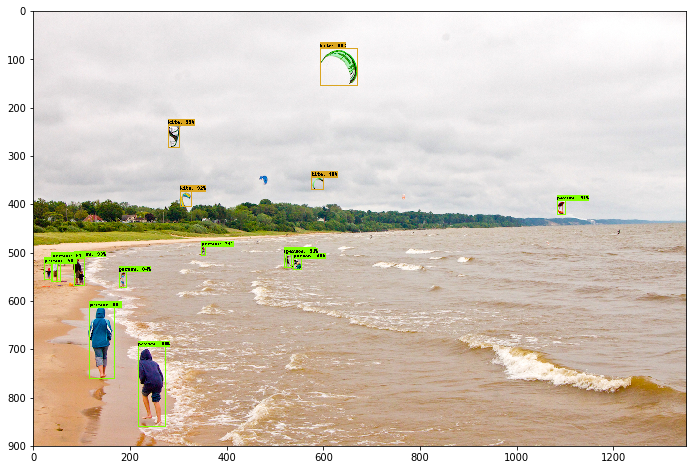

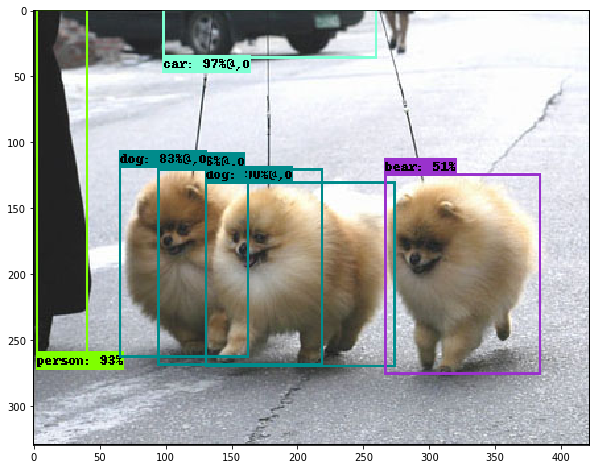

In [7]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=2)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

# Part 3. Object Detection with Custom-trained model
- 본 part는 tensorflow 기반에서 custom training model을 이용한 object detection 실습을 위한 part 입니다.
- 본 part의 실습은 Part 1. Install Tensorflow Object Detection modified API 가 우선 실행된 상태에서 실행되어야 합니다.

> Custom image detection model을 만드는 기본 원리
- Pretrain 되어서 제공되는 Model들은 대부분 coco dataset 을 기본 dataset으로 training 된 것들입니다.
- 따라서 coco dataset instance 에 없는 이미지를 detection 하기 위해서는 별도의 이미지 데이터를 준비하고  dataset 을 준비하여 transfer learning
- 일반적으로 다음의 순서로 진행 됩니다.
 - STEP 1. 데이터 수집 
 - STEP 2. 데이터 라벨링
 - STEP 3. label_map.pbtxt 파일 수정
 - STEP 4. TF RECORD 파일 생성
 - STEP 5. Transfer Learning & exporting
 - STEP 6. Export model 확인 및 이용
 
- 본인이 만들고 싶은 custom object detection model은 아래의 실습을 각 단계별로 따라하시면서 응용하면 됩니다.



## Step1. 데이터 수집
- 본 실습에서는 애니메이션 심슨가족 중 바트 심슨만을 detection 하는 것을 실습합니다.
- 별도로 제공된 images.zip 파일을 로컬 PC에서 압축 해제 합니다. 해당 폴더에는 바트 심슨 이미지들이 있습니다.
- 본 예제는 정확도 보다는 실습을 위한 것임으로 주어진 50개의 이미지만 학습 하는 것으로 진행합니다.

![step1_image](https://github.com/sunnys-lab/TF_object_detection_Modified_API/blob/master/doc/img/step1_image.JPG?raw=true)

## Step2. 데이터 라벨링
- 제공된 labelimg.exe (해당 실행파일은 windows OS 용입니다. 다른 OS를 사용하시는 분들은 각 OS에 맞는 labelimage 실행파일을 검색 및 다운로드하시어 사용하시면 됩니다.) 를 사용하여 원본 이미지와 오브젝트 영역을 저장한 xml 을 하나의 동일 폴더에 위치 시킵니다. ( 기본 폴더는 images 폴더입니다.)
- 본 실습에서는 바트 심슨 class 1개만을 대상으로 하지만, 하나의 이미지에 여러개의 라벨이 존재하도록 응용할 수 있습니다.
- Tip. 단축키 W 는 영역지정 A 는 이전 이미지 D 는 다음 이미지 Ctrl + S 는 저장입니다.
- 주어진 zip 폴더 안에는 이미 labelimg로 만들어진 xml 파일이 존재 합니다.
- 작업이 모두 완료된 경우  colab explorer 상에 업로드 (업로드 방법은 좌측 colab explorer 탭의 "파일" 탭에서 ./images 폴더 오른쪽 마우스 클릭 후 업로드 선택 -> 올리고자 하는 파일들 선택
- 본 예제에서는 이미 작업 완료된 해당 파일이 업로드 되어 있습니다.

![step2_image](https://github.com/sunnys-lab/TF_object_detection_Modified_API/blob/master/doc/img/step2_image.JPG?raw=true)
![step2_image](https://github.com/sunnys-lab/TF_object_detection_Modified_API/blob/master/doc/img/step2_image-2.JPG?raw=true)


## Step3. label_map.pbtxt 파일 수정
- 좌측 colab explorer 탭에서 "목차" 대신 "파일" 탭 선택 후 label_map.pbtxt 를 더블 클릭하여 다운 받은 후 detection 하고자 하는 레이블과 번호를 입력
- 본 예제에서는 class가 1개이고 바트 심슨만 detection 할 예정 임으로 아래와 같이 수정


```
item {
  id: 1
  name: 'simpson'
}
```

- 수정 후 다시 해당 파일을 colab explorer 상에 업로드 (업로드 방법은 좌측 colab explorer 탭의 "파일" 탭에서 업로드 선택 -> 검색창에서 올리고자 하는 파일 선택)
- 참고로 본 예제에서는 이미 해당 파일이 상기과 같이 변경되어 있는 상태입니다.

## Step4. TF RECORD 파일 생성
- tfgenerator.py 명령어를 수행하여, TF RECORD 파일을 생성합니다.
- 사용된 명령 파라미터 help 파일
```
('-m', '--max_num_classes', help='Maximum class number', default='90', type=int,required=False)
('-i','--input_folder',help='Input Images Forlder',default='./images/',type=str, required=False)
('-l', '--label_file', help='Label file Location', default='./label_map.pbtxt', type=str,required=False)
 ```

In [8]:
!python tfgenerator.py -m 1

[INFO|tfgenerator.py:168] 2019-06-30 16:02:21,959 > TF Record Generator Start
I0630 16:02:21.959455 139682416899968 tfgenerator.py:168] TF Record Generator Start
W0630 16:02:21.959838 139682416899968 deprecation_wrapper.py:119] From /content/object_detection/utils/label_map_util.py:131: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

[INFO|tfgenerator.py:21] 2019-06-30 16:02:21,964 >                 TF Record Summary                 
I0630 16:02:21.964561 139682416899968 tfgenerator.py:21]                 TF Record Summary                 
[INFO|tfgenerator.py:22] 2019-06-30 16:02:21,964 >     ID            NAME          Train    Validate 
I0630 16:02:21.964772 139682416899968 tfgenerator.py:22]     ID            NAME          Train    Validate 
[INFO|tfgenerator.py:24] 2019-06-30 16:02:21,964 >     1           simpson           40        10    
I0630 16:02:21.964884 139682416899968 tfgenerator.py:24]     1           simpson           40        10    
W063

## Step 5. Transfer Learning
- Hands-on에서는 동작 여부 확인을 위하여 Faster_Rcnn_Inception_v2_coco 모델을 가지고 200번 training 및 100번마다 evaluate 값을 확인
- 아래 코드 값 실행 후 model 은 4번 선택, step은 200 입력
- colab GPU 환경에서 실행시 해당 training은 약 5분 정도 소요
- 실제 상황에서는 보통 5,000 training 및 1,000 마다 evaluatioin 값 확인을 추천
- Colab에서 실행시 GPU 최고치 사용중 경고가 뜨는 경우가 발생 -> 무시하고 계속 진행


In [9]:
import os
os.environ['PYTHONPATH'] += ':/content/:/content/objectdetection/:/content/slim/'

!python main.py -n 100

+++++++++++++++++++++++++++++++++++
++++++ Auto re training tool ++++++
++++++        5TAKU          ++++++
+++++++++++++++++++++++++++++++++++

Select Model 

1. ssd_mobilenet_v1_coco 
2. ssd_mobilenet_v2_coco 
3. ssd_inception_v2_coco 
4. faster_rcnn_inception_v2_coco 
5. faster_rcnn_resnet50_coco 
6. faster_rcnn_resnet50_lowproposals_coco 
7. rfcn_resnet101_coco 
8. faster_rcnn_resnet101_coco 
9. faster_rcnn_resnet101_lowproposals_coco 
10. faster_rcnn_inception_resnet_v2_atrous_coco 
11. faster_rcnn_inception_resnet_v2_atrous_lowproposals_coco 
12. faster_rcnn_nas 
13. faster_rcnn_nas_lowproposals_coco 

Select Model Number : 4

Input number steps : 200

[INFO|main.py:92] 2019-06-30 16:05:28,287 > Program start [ model : faster_rcnn_inception_v2_coco_2018_01_28, num steps : 200 ]
[INFO|utils.py:79] 2019-06-30 16:05:28,287 > faster_rcnn_inception_v2_coco_2018_01_28 Model not Exist. Download start
146kKB [00:01, 75.9kKB/s]              
[INFO|utils.py:110] 2019-06-30 16:05:32,196 > f

## Step 6. Export model 확인 및 관련 이미지 test
- export_dir 폴더로 이동합니다.
- 좌측 colab explorer 탭의 "파일" 탭에서  ./export_dir/faster_rcnn_inception_v2_coco_2018_01_28 폴더 밑에  frozen_inference_graph.pb 파일이 존재하는지 확인합니다.
- 아래 소스코드를 순차적으로 시행시켜 결과를 확인 합니다.
- 결과 화면을 보시면 training 데이터 부족 및 training 횟수 부족으로 여러개의 Bounding box가 형성되는 것이 확인되었지만 실습 Hands-on은 끝까지 완주 하였습니다.

In [0]:
# What model to download.
# MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
# model with more accurancy but up to you use a diferent model
#MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2017_11_08'
#MODEL_FILE = MODEL_NAME + '.tar.gz'
#DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_CKPT = './export_dir/faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
#PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')
PATH_TO_LABELS = './label_map.pbtxt'

#NUM_CLASSES = 90
NUM_CLASSES = 1

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())
    
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = './test_images2'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

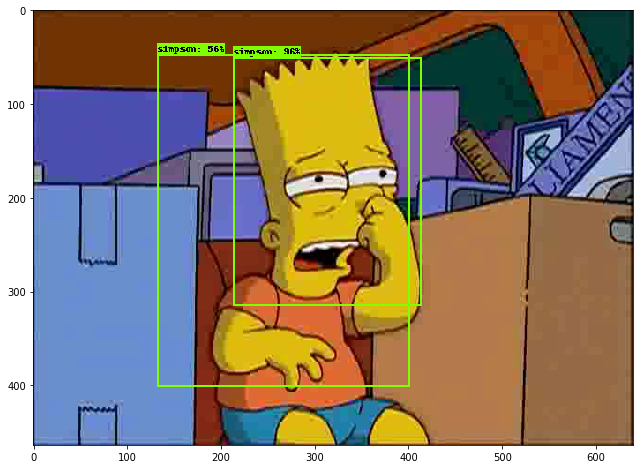

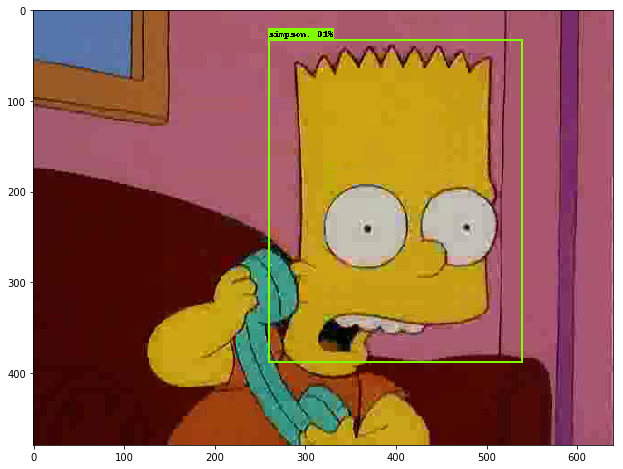

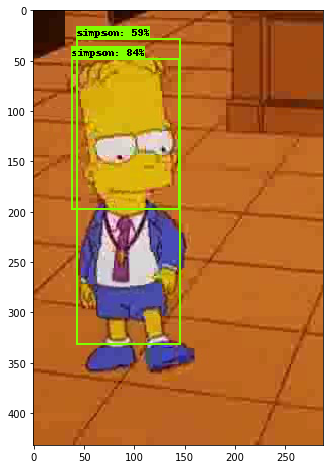

In [13]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=2)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)